https://wrds-www.wharton.upenn.edu/pages/wrds-research/applications/python-replications/historical-sp-500-index-constituents

https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-security-files/daily-stock-file/

https://wrds-www.wharton.upenn.edu/data-dictionary/contrib_global_factor/global_factor/

In [1]:
import pandas as pd
import wrds
from matplotlib import pyplot as plt

In [2]:
conn = wrds.Connection()

Enter your WRDS username [osx]:chunnijiang
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [3]:
begdate = '2015-01-01'
enddate = '2022-12-30'

Get S&P 500 Constituent

In [4]:
sp500 = conn.raw_sql(f"""
                        select a.*, b.date
                        from crsp.msp500list as a,
                        crsp.msf as b
                        where a.permno=b.permno
                        and b.date >= a.start and b.date<= a.ending
                        and b.date>='{begdate}'
                        and b.date<='{enddate}'
                        order by date;
                        """, date_cols=['start', 'ending', 'date'])

In [5]:
mse = conn.raw_sql("""
                        select comnam, namedt, nameendt, 
                        permno, ticker
                        from crsp.msenames
                        """, date_cols=['namedt', 'nameendt'])

# if nameendt is missing then set to today date
mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

In [6]:
# Merge with SP500 data
sp500_full = pd.merge(sp500, mse, how = 'left', on = 'permno')

# Impose the date range restrictions
sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                            & (sp500_full.date<=sp500_full.nameendt)]

In [7]:
sp500 = sp500_full.drop_duplicates('permno')
sp500 = sp500[['permno', 'comnam', 'ticker']]
sp500

,permno,comnam,ticker
3,49154,TARGET CORP,TGT
11,70033,HARLEY DAVIDSON INC,HOG
17,89626,C M E GROUP INC,CME
31,71563,B B & T CORP,BBT
38,91461,WESTERN UNION CO,WU
...,...,...,...
340129,16581,INVITATION HOMES INC,INVH
340917,86288,COSTAR GROUP INC,CSGP
342137,12476,TARGA RESOURCES CORP,TRGP
347621,82276,ARCH CAPITAL GROUP LTD NEW,ACGL


Read Price Volume data for S&P500

In [8]:
permno_list_sp500 = sp500['permno'].astype('int').to_list()
formatted_permnos_sp500 = ",".join(["'{}'".format(permno) for permno in permno_list_sp500])

In [9]:
query = f"""
SELECT 
    permno, date, prc, vol, openprc, askhi, bidlo, ret, shrout
FROM 
    crsp_a_stock.dsf 
WHERE 
    permno IN ({formatted_permnos_sp500}) AND date BETWEEN '{begdate}' AND '{enddate}'
"""

price_vol_sp500 = conn.raw_sql(query)

In [10]:
price_vol_sp500['date'] = pd.to_datetime(price_vol_sp500['date'])
price_vol_sp500['yyyy-mm'] = price_vol_sp500['date'].dt.strftime('%Y-%m')

In [11]:
price_vol_sp500['value'] = price_vol_sp500['prc']*price_vol_sp500['shrout']
price_vol_sp500['mkt_port'] = price_vol_sp500.groupby('date')['value'].transform('sum')
price_vol_sp500['mkt_port_weight'] = price_vol_sp500['prc']*price_vol_sp500['shrout']/price_vol_sp500['mkt_port']
price_vol_sp500.drop(columns = ['value', 'mkt_port'], inplace=True)

In [12]:
price_vol_sp500

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,mkt_port_weight
0,10516,2015-01-02,52.02,2039815.0,52.20,52.6000,51.5900,0.000385,643788.0,2015-01,0.001673
1,10145,2015-01-02,100.23,2128832.0,100.20,100.8500,99.1000,0.003103,782810.0,2015-01,0.003919
2,10145,2015-01-05,98.32,3158662.0,99.90,99.9000,98.0000,-0.019056,782810.0,2015-01,0.003915
3,10145,2015-01-06,98.09,4234040.0,98.30,99.4900,97.5300,-0.002339,782810.0,2015-01,0.003941
4,10145,2015-01-07,98.80,2610530.0,99.07,99.8500,98.4900,0.007238,782810.0,2015-01,0.003923
...,...,...,...,...,...,...,...,...,...,...,...
221715,93246,2022-12-23,92.19,1292660.0,90.00,92.2400,89.2100,0.026729,63356.0,2022-12,0.000173
221716,93246,2022-12-27,91.15,1188363.0,92.42,92.4200,88.8400,-0.011281,63356.0,2022-12,0.000171
221717,93246,2022-12-28,96.24,3369646.0,93.55,96.6200,92.4300,0.055842,63356.0,2022-12,0.000183
221718,93246,2022-12-29,100.64,2894946.0,97.24,102.7300,95.8900,0.045719,63356.0,2022-12,0.000188


Get a larger universe, where mktcap > 300M and dollar vol > 10M

In [13]:
query = f"""
SELECT 
    DISTINCT permno, date, market_equity, dolvol_126d, excntry, gics
FROM 
    contrib_global_factor.global_factor
WHERE
    date ='{enddate}' AND excntry = 'USA'
"""

all = conn.raw_sql(query)

In [14]:
all.dropna(inplace=True)
all = all[(all['market_equity'] > 300) & (all['dolvol_126d'] > 10e6)]
all

,permno,date,market_equity,dolvol_126d,excntry,gics
4,91915.0,2022-12-30,1042.880482,3.968570e+07,USA,50202010.0
34,90979.0,2022-12-30,1917.080211,6.701488e+07,USA,25203010.0
55,19893.0,2022-12-30,339.862022,5.008955e+07,USA,50203010.0
75,21895.0,2022-12-30,2369.825136,2.436594e+07,USA,45103010.0
97,13783.0,2022-12-30,830.915008,2.862788e+07,USA,15104040.0
...,...,...,...,...,...,...
26446,20053.0,2022-12-30,5461.947789,4.016017e+07,USA,40101015.0
26454,79444.0,2022-12-30,1558.921531,2.367499e+07,USA,10102020.0
26485,17676.0,2022-12-30,6408.602093,2.837874e+07,USA,20104010.0
26494,88462.0,2022-12-30,1183.638297,8.008280e+07,USA,35202010.0


In [15]:
all = pd.merge(all, mse, how='left', on='permno')
all = all.drop_duplicates('permno')
all = all[['permno', 'comnam', 'ticker']]
all

,permno,comnam,ticker
0,91915.0,CINEMARK HOLDINGS INC,CNK
3,90979.0,UNDER ARMOUR INC,UARM
12,19893.0,FUBOTV INC,FUBO
13,21895.0,FRESHWORKS INC,FRSH
14,13783.0,SIBANYE GOLD LTD,SBGL
...,...,...,...
10796,20053.0,C B & T BANCSHARES INC,CBTB
10806,79444.0,STONE ENERGY CORP,SGY
10817,17676.0,NVENT ELECTRIC PLC,NVT
10819,88462.0,PAIN THERAPEUTICS INC,PTIE


Read Price Volume data for our universe

In [16]:
permno_list_all = all['permno'].astype('int').to_list()
formatted_permnos_all = ",".join(["'{}'".format(permno) for permno in permno_list_all])

In [17]:
query = f"""
SELECT 
    permno, date, prc, vol, openprc, askhi, bidlo, ret, shrout
FROM 
    crsp_a_stock.dsf 
WHERE 
    permno IN ({formatted_permnos_all}) AND date BETWEEN '{begdate}' AND '{enddate}'
"""

price_vol_all = conn.raw_sql(query)

In [18]:
price_vol_all['date'] = pd.to_datetime(price_vol_all['date'])
price_vol_all['yyyy-mm'] = price_vol_all['date'].dt.strftime('%Y-%m')
price_vol_all = price_vol_all.merge(price_vol_sp500[['permno', 'date', 'mkt_port_weight']], on=['permno', 'date'], how = 'left').fillna(0)
price_vol_all

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,mkt_port_weight
0,10026,2015-01-02,107.69,88837.0,109.18,109.4460,106.810,-0.009929,18678.0,2015-01,0.0
1,10026,2015-01-05,107.24,61805.0,107.41,108.4300,106.760,-0.004179,18678.0,2015-01,0.0
2,10026,2015-01-06,107.27,80455.0,107.84,108.6900,106.185,0.000280,18678.0,2015-01,0.0
3,10026,2015-01-07,108.73,58792.0,107.70,108.7700,106.495,0.013611,18678.0,2015-01,0.0
4,10026,2015-01-08,110.32,56302.0,109.48,111.2800,109.110,0.014623,18678.0,2015-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3628576,84084,2022-12-23,65.97,224425.0,62.92,66.0700,61.845,0.053497,12728.0,2022-12,0.0
3628577,84084,2022-12-27,68.19,250147.0,66.29,68.2900,65.960,0.033652,12728.0,2022-12,0.0
3628578,84084,2022-12-28,66.41,316630.0,67.88,68.7290,65.160,-0.026104,12728.0,2022-12,0.0
3628579,84084,2022-12-29,69.63,320989.0,67.35,70.4250,66.265,0.048487,12728.0,2022-12,0.0


Read GICS data for sp500

In [19]:
query = f"""
SELECT 
    DISTINCT permno, gics, date
FROM 
    contrib_global_factor.global_factor
WHERE
    permno IN ({formatted_permnos_sp500}) AND date BETWEEN '{begdate}' AND '{enddate}'
"""

gics_sp500 = conn.raw_sql(query)

In [20]:
gics_sp500['date'] = pd.to_datetime(gics_sp500['date'])
gics_sp500['yyyy-mm'] = gics_sp500['date'].dt.strftime('%Y-%m')
gics_sp500.drop(columns='date', inplace=True)
gics_sp500

,permno,gics,yyyy-mm
0,87717.0,20301010.0,2019-12
1,19502.0,30101010.0,2020-06
2,44329.0,35101010.0,2021-07
3,60442.0,40101015.0,2018-09
4,24328.0,10102020.0,2015-07
...,...,...,...
58326,92157.0,45203020.0,2018-12
58327,58246.0,40203010.0,2021-07
58328,10516.0,30202010.0,2015-10
58329,89641.0,45202030.0,2015-12


Merge price_vol and GICS information for sp500

In [21]:
price_vol_gics_sp500 = pd.merge(price_vol_sp500, gics_sp500, how='left', on=['permno', 'yyyy-mm'])
price_vol_gics_sp500 = pd.merge(price_vol_gics_sp500, sp500, how='left', on=['permno'])
price_vol_gics_sp500

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,mkt_port_weight,gics,comnam,ticker
0,10516,2015-01-02,52.02,2039815.0,52.20,52.6000,51.5900,0.000385,643788.0,2015-01,0.001673,30202010.0,ARCHER DANIELS MIDLAND CO,ADM
1,10145,2015-01-02,100.23,2128832.0,100.20,100.8500,99.1000,0.003103,782810.0,2015-01,0.003919,20101010.0,HONEYWELL INTERNATIONAL INC,HON
2,10145,2015-01-05,98.32,3158662.0,99.90,99.9000,98.0000,-0.019056,782810.0,2015-01,0.003915,20101010.0,HONEYWELL INTERNATIONAL INC,HON
3,10145,2015-01-06,98.09,4234040.0,98.30,99.4900,97.5300,-0.002339,782810.0,2015-01,0.003941,20101010.0,HONEYWELL INTERNATIONAL INC,HON
4,10145,2015-01-07,98.80,2610530.0,99.07,99.8500,98.4900,0.007238,782810.0,2015-01,0.003923,20101010.0,HONEYWELL INTERNATIONAL INC,HON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221715,93246,2022-12-23,92.19,1292660.0,90.00,92.2400,89.2100,0.026729,63356.0,2022-12,0.000173,20104010.0,GENERAC HOLDINGS INC,GNRC
1221716,93246,2022-12-27,91.15,1188363.0,92.42,92.4200,88.8400,-0.011281,63356.0,2022-12,0.000171,20104010.0,GENERAC HOLDINGS INC,GNRC
1221717,93246,2022-12-28,96.24,3369646.0,93.55,96.6200,92.4300,0.055842,63356.0,2022-12,0.000183,20104010.0,GENERAC HOLDINGS INC,GNRC
1221718,93246,2022-12-29,100.64,2894946.0,97.24,102.7300,95.8900,0.045719,63356.0,2022-12,0.000188,20104010.0,GENERAC HOLDINGS INC,GNRC


Read GICS data for our universe

In [22]:
query = f"""
SELECT 
    DISTINCT permno, gics, date
FROM 
    contrib_global_factor.global_factor
WHERE
    permno IN ({formatted_permnos_all}) AND date BETWEEN '{begdate}' AND '{enddate}'
"""

gics_all = conn.raw_sql(query)

In [23]:
gics_all['date'] = pd.to_datetime(gics_all['date'])
gics_all['yyyy-mm'] = gics_all['date'].dt.strftime('%Y-%m')
gics_all.drop(columns='date', inplace=True)
gics_all

,permno,gics,yyyy-mm
0,15071.0,35203010.0,2016-07
1,19502.0,30101010.0,2020-06
2,20583.0,10102020.0,2022-10
3,44329.0,35101010.0,2021-07
4,24328.0,10102020.0,2015-07
...,...,...,...
173714,24969.0,55103010.0,2022-02
173715,18770.0,35201010.0,2021-07
173716,14071.0,60101060.0,2020-02
173717,85234.0,20201080.0,2021-06


Merge price_vol and GICS information for sp500

In [24]:
price_vol_gics_all = pd.merge(price_vol_all, gics_all, how='left', on=['permno', 'yyyy-mm'])
price_vol_gics_all = pd.merge(price_vol_gics_all, all, how='left', on=['permno'])
price_vol_gics_all

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,mkt_port_weight,gics,comnam,ticker
0,10026,2015-01-02,107.69,88837.0,109.18,109.4460,106.810,-0.009929,18678.0,2015-01,0.0,30202030.0,J & J SNACK FOODS CORP,JJSF
1,10026,2015-01-05,107.24,61805.0,107.41,108.4300,106.760,-0.004179,18678.0,2015-01,0.0,30202030.0,J & J SNACK FOODS CORP,JJSF
2,10026,2015-01-06,107.27,80455.0,107.84,108.6900,106.185,0.000280,18678.0,2015-01,0.0,30202030.0,J & J SNACK FOODS CORP,JJSF
3,10026,2015-01-07,108.73,58792.0,107.70,108.7700,106.495,0.013611,18678.0,2015-01,0.0,30202030.0,J & J SNACK FOODS CORP,JJSF
4,10026,2015-01-08,110.32,56302.0,109.48,111.2800,109.110,0.014623,18678.0,2015-01,0.0,30202030.0,J & J SNACK FOODS CORP,JJSF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3628576,84084,2022-12-23,65.97,224425.0,62.92,66.0700,61.845,0.053497,12728.0,2022-12,0.0,25504040.0,HIBBETT SPORTING GOODS INC,HIBB
3628577,84084,2022-12-27,68.19,250147.0,66.29,68.2900,65.960,0.033652,12728.0,2022-12,0.0,25504040.0,HIBBETT SPORTING GOODS INC,HIBB
3628578,84084,2022-12-28,66.41,316630.0,67.88,68.7290,65.160,-0.026104,12728.0,2022-12,0.0,25504040.0,HIBBETT SPORTING GOODS INC,HIBB
3628579,84084,2022-12-29,69.63,320989.0,67.35,70.4250,66.265,0.048487,12728.0,2022-12,0.0,25504040.0,HIBBETT SPORTING GOODS INC,HIBB


Save to parquet

In [25]:
price_vol_gics_sp500.to_parquet('../data/price_vol_gics_sp500.parquet.gzip', compression='gzip')
price_vol_gics_all.to_parquet('../data/price_vol_gics_all.parquet.gzip', compression='gzip')

In [26]:
conn.close()

GICS map

Note that according to GICS 2023 standard, some names have changed.

In [27]:
sector_map = {
    10: 'Energy',
    15: 'Materials',
    20: 'Industrials',
    25: 'Consumer Discretionary',
    30: 'Consumer Staples',
    35: 'Health Care',
    40: 'Financials',
    45: 'Information Technology',
    50: 'Communication Services',
    55: 'Utilities',
    60: 'Real Estate'
}

In [28]:
industry_group_map = {
    1010: 'Energy',
    1510: 'Materials',
    2010: 'Capital Goods',
    2020: 'Commercial & Professional Services',
    2030: 'Transportation',
    2510: 'Automobiles & Components',
    2520: 'Consumer Durables & Apparel',
    2530: 'Consumer Services',
    2550: 'Consumer Discretionary Distribution & Retail',
    3010: 'Consumer Staples Distribution & Retail',
    3020: 'Food, Beverage & Tobacco',
    3030: 'Household & Personal Products',
    3510: 'Health Care Equipment & Services',
    3520: 'Pharmaceuticals, Biotechnology & Life Sciences',
    4010: 'Banks',
    4020: 'Financial Services',
    4030: 'Insurance',
    4510: 'Software & Services',
    4520: 'Technology Hardware & Equipment',
    4530: 'Semiconductors & Semiconductor Equipment',
    5010: 'Telecommunication Services',
    5020: 'Media & Entertainment',
    5510: 'Utilities',
    6010: 'Equity Real Estate Investment Trusts (REITs)',
    6020: 'Real Estate Management & Development'
}


# Merge industry gics

sp500

In [29]:
import pyarrow.parquet as pq

# Specify the path to your parquet.gzip file
parquet_file_path = '../data/holdings_hf.parquet.gzip'

# Read the Parquet file using pyarrow
holdings = pq.read_table(parquet_file_path)

# Convert the table to a Pandas DataFrame if needed
holdings = holdings.to_pandas()

holdings.head()

,rdate,mgrno,first_report,last_report,shares,permno,shares_adj,phrdate,pshares_adj,trade,qtrgap,lpermno,npermno
262475,2018-12-31,127.0,False,False,290920.0,12373,290920.0,2018-09-30,220707.0,70213.0,1,NaN,12373.0
262376,2019-03-31,127.0,False,False,269088.0,12373,269088.0,2018-12-31,290920.0,-21832.0,1,12373.0,12373.0
262271,2019-06-30,127.0,False,True,204225.0,12373,204225.0,2019-03-31,269088.0,-64863.0,1,12373.0,12513.0
232546,2015-06-30,127.0,False,False,1517954.0,12513,1517954.0,2015-03-31,1502354.0,15600.0,1,12373.0,12513.0
232501,2015-09-30,127.0,False,False,1387792.0,12513,1387792.0,2015-06-30,1517954.0,-130162.0,1,12513.0,12513.0


In [30]:
parquet_file_path = '../data/price_vol_gics_sp500.parquet.gzip'

# Read the Parquet file using pyarrow
price_vol_gics_sp500 = pq.read_table(parquet_file_path)

# Convert the table to a Pandas DataFrame if needed
price_vol_gics_sp500 = price_vol_gics_sp500.to_pandas()

price_vol_gics_sp500.head()

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,mkt_port_weight,gics,comnam,ticker
0,10516,2015-01-02,52.02,2039815.0,52.20,52.60,51.59,0.000385,643788.0,2015-01,0.001673,30202010.0,ARCHER DANIELS MIDLAND CO,ADM
1,10145,2015-01-02,100.23,2128832.0,100.20,100.85,99.10,0.003103,782810.0,2015-01,0.003919,20101010.0,HONEYWELL INTERNATIONAL INC,HON
2,10145,2015-01-05,98.32,3158662.0,99.90,99.90,98.00,-0.019056,782810.0,2015-01,0.003915,20101010.0,HONEYWELL INTERNATIONAL INC,HON
3,10145,2015-01-06,98.09,4234040.0,98.30,99.49,97.53,-0.002339,782810.0,2015-01,0.003941,20101010.0,HONEYWELL INTERNATIONAL INC,HON
4,10145,2015-01-07,98.80,2610530.0,99.07,99.85,98.49,0.007238,782810.0,2015-01,0.003923,20101010.0,HONEYWELL INTERNATIONAL INC,HON


In [31]:
holdings = holdings.rename(columns = {'rdate':'date'})
holdings['year'] = holdings['date'].dt.year

In [32]:
holdings_sp500 = holdings[holdings['permno'].isin(price_vol_gics_sp500['permno'])]
holdings_sp500 = holdings_sp500.sort_values(['permno', 'date', 'mgrno'])
tmp = pd.merge(holdings_sp500, price_vol_gics_sp500, on = ['date', 'permno'], how = 'outer')
tmp = tmp.sort_values(['permno', 'date'])
tmp[price_vol_gics_sp500.columns] = tmp.groupby('permno')[price_vol_gics_sp500.columns].ffill()
holdings_sp500 = tmp.set_index(['permno', 'date', 'mgrno']).reindex(holdings_sp500.set_index(['permno', 'date', 'mgrno']).index)
holdings_sp500['gics'] = holdings_sp500['gics'].fillna(0)
holdings_sp500.head()

first_report last_report     shares  shares_adj  \
permno date       mgrno                                                    
10104  2015-06-30 185.0         False       False  2728420.0   2728420.0   
                  220.0         False       False    39653.0     39653.0   
                  1300.0        False       False   719000.0    719000.0   
                  1371.0        False       False   163277.0    163277.0   
                  4100.0        False       False   291970.0    291970.0   

                            phrdate  pshares_adj    trade  qtrgap  lpermno  \
permno date       mgrno                                                      
10104  2015-06-30 185.0  2015-03-31    2752471.0 -24051.0     1.0  10065.0   
                  220.0  2015-03-31      54992.0 -15339.0     1.0  10066.0   
                  1300.0 2015-03-31     625700.0  93300.0     1.0  93096.0   
                  1371.0 2015-03-31     153249.0  10028.0     1.0  93419.0   
                  4100.0 2015-03-31     279770.0  12200.0     1.0  10028.0   

                          npermno  ...  openprc  askhi  bidlo       ret  \
permno date       mgrno            ...                                    
10104  2015-06-30 185.0   10104.0  ...     40.6  40.75  40.11 -0.002969   
                  220.0   10104.0  ...     40.6  40.75  40.11 -0.002969   
                  1300.0  10104.0  ...     40.6  40.75  40.11 -0.002969   
                  1371.0  10104.0  ...     40.6  40.75  40.11 -0.002969   
                  4100.0  10104.0  ...     40.6  40.75  40.11 -0.002969   

                             shrout  yyyy-mm  mkt_port_weight        gics  \
permno date       mgrno                                                     
10104  2015-06-30 185.0   4336077.0  2015-06         0.008737  45103020.0   
                  220.0   4336077.0  2015-06         0.008737  45103020.0   
                  1300.0  4336077.0  2015-06         0.008737  45103020.0   
                  1371.0  4336077.0  2015-06         0.008737  45103020.0   
                  4100.0  4336077.0  2015-06         0.008737  45103020.0   

                               comnam  ticker  
permno date       mgrno                        
10104  2015-06-30 185.0   ORACLE CORP    ORCL  
                  220.0   ORACLE CORP    ORCL  
                  1300.0  ORACLE CORP    ORCL  
                  1371.0  ORACLE CORP    ORCL  
                  4100.0  ORACLE CORP    ORCL  

[5 rows x 23 columns]

In [33]:
holdings_sp500['gics1'] = holdings_sp500['gics'].apply(lambda x:sector_map[int(x//1e6)] if int(x//1e6) in sector_map.keys() else 'Unknown')
holdings_sp500['gics2'] = holdings_sp500['gics'].apply(lambda x:industry_group_map[int(x//1e4)]if int(x//1e4) in industry_group_map.keys() else 'Unknown')

holdings_sp500.head()

first_report last_report     shares  shares_adj  \
permno date       mgrno                                                    
10104  2015-06-30 185.0         False       False  2728420.0   2728420.0   
                  220.0         False       False    39653.0     39653.0   
                  1300.0        False       False   719000.0    719000.0   
                  1371.0        False       False   163277.0    163277.0   
                  4100.0        False       False   291970.0    291970.0   

                            phrdate  pshares_adj    trade  qtrgap  lpermno  \
permno date       mgrno                                                      
10104  2015-06-30 185.0  2015-03-31    2752471.0 -24051.0     1.0  10065.0   
                  220.0  2015-03-31      54992.0 -15339.0     1.0  10066.0   
                  1300.0 2015-03-31     625700.0  93300.0     1.0  93096.0   
                  1371.0 2015-03-31     153249.0  10028.0     1.0  93419.0   
                  4100.0 2015-03-31     279770.0  12200.0     1.0  10028.0   

                          npermno  ...  bidlo       ret     shrout  yyyy-mm  \
permno date       mgrno            ...                                        
10104  2015-06-30 185.0   10104.0  ...  40.11 -0.002969  4336077.0  2015-06   
                  220.0   10104.0  ...  40.11 -0.002969  4336077.0  2015-06   
                  1300.0  10104.0  ...  40.11 -0.002969  4336077.0  2015-06   
                  1371.0  10104.0  ...  40.11 -0.002969  4336077.0  2015-06   
                  4100.0  10104.0  ...  40.11 -0.002969  4336077.0  2015-06   

                          mkt_port_weight        gics       comnam  ticker  \
permno date       mgrno                                                      
10104  2015-06-30 185.0          0.008737  45103020.0  ORACLE CORP    ORCL   
                  220.0          0.008737  45103020.0  ORACLE CORP    ORCL   
                  1300.0         0.008737  45103020.0  ORACLE CORP    ORCL   
                  1371.0         0.008737  45103020.0  ORACLE CORP    ORCL   
                  4100.0         0.008737  45103020.0  ORACLE CORP    ORCL   

                                           gics1                gics2  
permno date       mgrno                                                
10104  2015-06-30 185.0   Information Technology  Software & Services  
                  220.0   Information Technology  Software & Services  
                  1300.0  Information Technology  Software & Services  
                  1371.0  Information Technology  Software & Services  
                  4100.0  Information Technology  Software & Services  

[5 rows x 25 columns]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

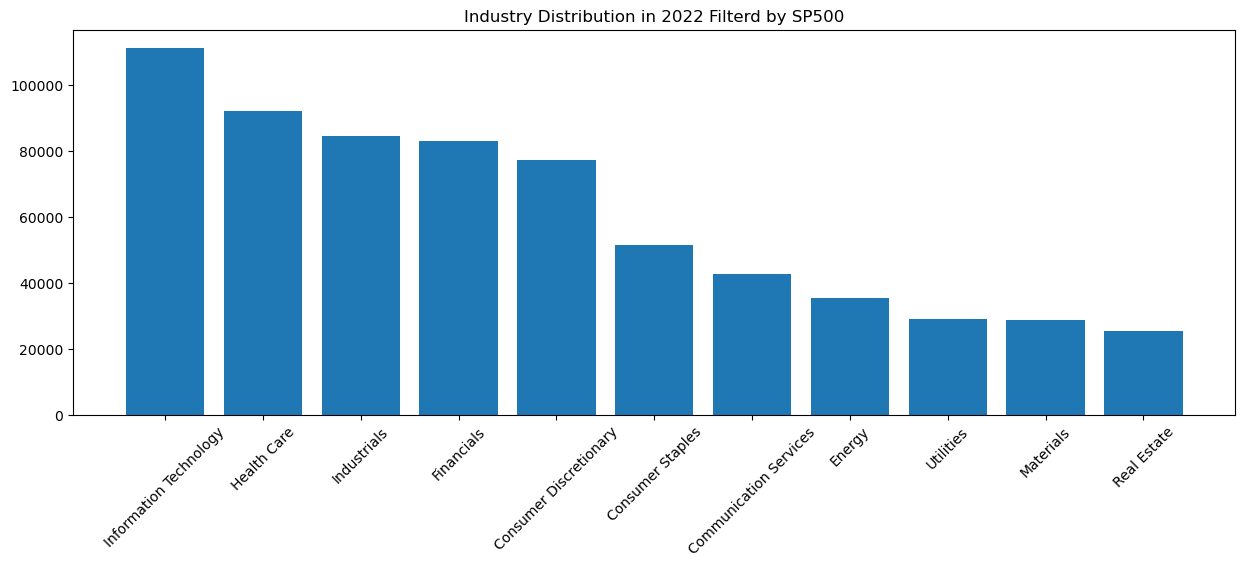

In [34]:
recent_holdings = holdings_sp500[holdings_sp500['year']==2022]
industry = recent_holdings['gics1'].value_counts()

plt.figure(figsize = (15,5))
plt.bar(industry.index, industry)
plt.title('Industry Distribution in 2022 Filterd by SP500')
plt.xticks(rotation = 45)

In [35]:
holdings_sp500.to_parquet('../data/holdings_sp500_hf.parquet.gzip', compression='gzip')

all universe

In [36]:
parquet_file_path = '../data/price_vol_gics_all.parquet.gzip'
price_vol_gics_all = pq.read_table(parquet_file_path)
price_vol_gics_all = price_vol_gics_all.to_pandas()

In [37]:
holdings_all = holdings[holdings['permno'].isin(price_vol_gics_all['permno'])]
holdings_all = holdings_all.sort_values(['permno', 'date', 'mgrno'])
tmp = pd.merge(holdings_all, price_vol_gics_all, on = ['date', 'permno'], how = 'outer')
tmp = tmp.sort_values(['permno', 'date'])
tmp[price_vol_gics_all.columns] = tmp.groupby('permno')[price_vol_gics_all.columns].ffill()
holdings_all = tmp.set_index(['permno', 'date', 'mgrno']).reindex(holdings_all.set_index(['permno', 'date', 'mgrno']).index)
holdings_all['gics'] = holdings_all['gics'].fillna(0)
holdings_all.head()

first_report last_report    shares  shares_adj  \
permno date       mgrno                                                   
10026  2015-06-30 3940.0        False       False    5063.0      5063.0   
                  4900.0        False       False  302283.0    302283.0   
                  6132.0        False       False   14863.0     14863.0   
                  7633.0        False       False    2804.0      2804.0   
                  7634.0        False       False    2065.0      2065.0   

                            phrdate  pshares_adj   trade  qtrgap  lpermno  \
permno date       mgrno                                                     
10026  2015-06-30 3940.0 2015-03-31       5063.0     0.0     1.0  10025.0   
                  4900.0 2015-03-31     302106.0   177.0     1.0  93436.0   
                  6132.0 2015-03-31      19645.0 -4782.0     1.0  10025.0   
                  7633.0 2015-03-31       3740.0  -936.0     1.0  93436.0   
                  7634.0 2015-03-31       1985.0    80.0     1.0  93436.0   

                          npermno  ...  openprc    askhi   bidlo       ret  \
permno date       mgrno            ...                                       
10026  2015-06-30 3940.0  10026.0  ...   111.01  112.335  109.98 -0.001714   
                  4900.0  10026.0  ...   111.01  112.335  109.98 -0.001714   
                  6132.0  10026.0  ...   111.01  112.335  109.98 -0.001714   
                  7633.0  10026.0  ...   111.01  112.335  109.98 -0.001714   
                  7634.0  10026.0  ...   111.01  112.335  109.98 -0.001714   

                           shrout  yyyy-mm  mkt_port_weight        gics  \
permno date       mgrno                                                   
10026  2015-06-30 3940.0  18692.0  2015-06              0.0  30202030.0   
                  4900.0  18692.0  2015-06              0.0  30202030.0   
                  6132.0  18692.0  2015-06              0.0  30202030.0   
                  7633.0  18692.0  2015-06              0.0  30202030.0   
                  7634.0  18692.0  2015-06              0.0  30202030.0   

                                          comnam  ticker  
permno date       mgrno                                   
10026  2015-06-30 3940.0  J & J SNACK FOODS CORP    JJSF  
                  4900.0  J & J SNACK FOODS CORP    JJSF  
                  6132.0  J & J SNACK FOODS CORP    JJSF  
                  7633.0  J & J SNACK FOODS CORP    JJSF  
                  7634.0  J & J SNACK FOODS CORP    JJSF  

[5 rows x 23 columns]

In [38]:
holdings_all['gics1'] = holdings_all['gics'].apply(lambda x:sector_map[int(x//1e6)] if int(x//1e6) in sector_map.keys() else 'Unknown')
holdings_all['gics2'] = holdings_all['gics'].apply(lambda x:industry_group_map[int(x//1e4)]if int(x//1e4) in industry_group_map.keys() else 'Unknown')

holdings_all.head()

first_report last_report    shares  shares_adj  \
permno date       mgrno                                                   
10026  2015-06-30 3940.0        False       False    5063.0      5063.0   
                  4900.0        False       False  302283.0    302283.0   
                  6132.0        False       False   14863.0     14863.0   
                  7633.0        False       False    2804.0      2804.0   
                  7634.0        False       False    2065.0      2065.0   

                            phrdate  pshares_adj   trade  qtrgap  lpermno  \
permno date       mgrno                                                     
10026  2015-06-30 3940.0 2015-03-31       5063.0     0.0     1.0  10025.0   
                  4900.0 2015-03-31     302106.0   177.0     1.0  93436.0   
                  6132.0 2015-03-31      19645.0 -4782.0     1.0  10025.0   
                  7633.0 2015-03-31       3740.0  -936.0     1.0  93436.0   
                  7634.0 2015-03-31       1985.0    80.0     1.0  93436.0   

                          npermno  ...   bidlo       ret   shrout  yyyy-mm  \
permno date       mgrno            ...                                       
10026  2015-06-30 3940.0  10026.0  ...  109.98 -0.001714  18692.0  2015-06   
                  4900.0  10026.0  ...  109.98 -0.001714  18692.0  2015-06   
                  6132.0  10026.0  ...  109.98 -0.001714  18692.0  2015-06   
                  7633.0  10026.0  ...  109.98 -0.001714  18692.0  2015-06   
                  7634.0  10026.0  ...  109.98 -0.001714  18692.0  2015-06   

                          mkt_port_weight        gics                  comnam  \
permno date       mgrno                                                         
10026  2015-06-30 3940.0              0.0  30202030.0  J & J SNACK FOODS CORP   
                  4900.0              0.0  30202030.0  J & J SNACK FOODS CORP   
                  6132.0              0.0  30202030.0  J & J SNACK FOODS CORP   
                  7633.0              0.0  30202030.0  J & J SNACK FOODS CORP   
                  7634.0              0.0  30202030.0  J & J SNACK FOODS CORP   

                          ticker             gics1                     gics2  
permno date       mgrno                                                       
10026  2015-06-30 3940.0    JJSF  Consumer Staples  Food, Beverage & Tobacco  
                  4900.0    JJSF  Consumer Staples  Food, Beverage & Tobacco  
                  6132.0    JJSF  Consumer Staples  Food, Beverage & Tobacco  
                  7633.0    JJSF  Consumer Staples  Food, Beverage & Tobacco  
                  7634.0    JJSF  Consumer Staples  Food, Beverage & Tobacco  

[5 rows x 25 columns]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

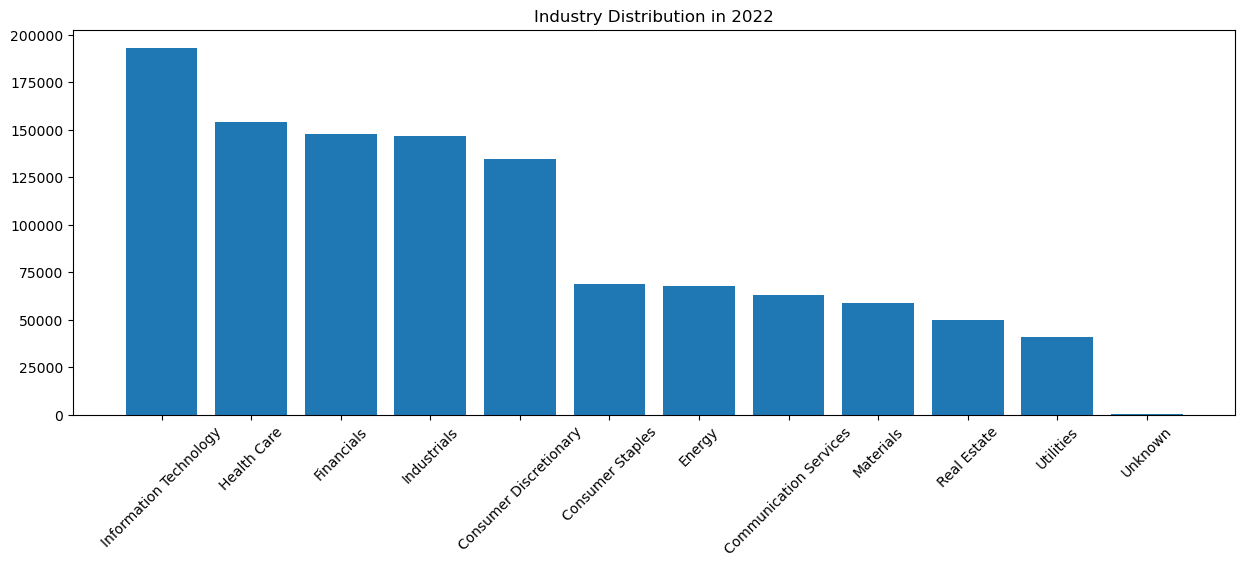

In [39]:
recent_holdings = holdings_all[holdings_all['year']==2022]
industry = recent_holdings['gics1'].value_counts()

plt.figure(figsize = (15,5))
plt.bar(industry.index, industry)
plt.title('Industry Distribution in 2022')
plt.xticks(rotation = 45)

In [41]:
holdings_all.to_parquet('../data/holdings_all_hf.parquet.gzip', compression='gzip')